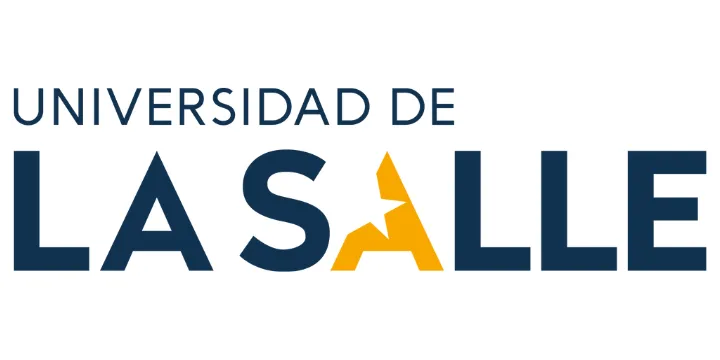



---



** Predicción de nacimientos en Colombia (2020-2024)**

$$Rodolfo Rodriguez Sarmiento\_2025-grupo2$$
$$Juan Pablo Garzón Dueñas\_2025-grupo2$$
$$AlexanderDavidVargasLeón\_2025-grupo1$$


**Archivo adjunto entregado:** cuaderno exportado `.html`

In [ ]:
# ======================================
# TRABAJO GRUPAL - PREDICCIÓN DE NACIMIENTOS COLOMBIA (2020–2024)
# ======================================
import os #permite interactuar con el sistema (crear carpetas, leer archivos, etc.).
import io #manejo de flujos de entrada/salida (leer archivos directamente desde memoria o Internet).
import requests #permite descargar archivos o datos desde URLs (por ejemplo, los datos del DANE).
import numpy as np #librería de cálculo numérico eficiente (vectores, matrices, estadísticas).
import pandas as pd #la más usada para manejar y limpiar datos tabulares (tipo Excel).
from pathlib import Path #facilita trabajar con rutas de carpetas y archivos (más limpio que usar os.path).
###################Librerías de machine learning#########################
#train_test_split divide tus datos en entrenamiento y prueba (para evaluar el modelo).
#cross_val_score / cross_val_predict validación cruzada (mide precisión en varios subconjuntos).
#LinearRegression modelo de regresión lineal (predicciones simples).
#RandomForestRegressor  modelo más avanzado basado en árboles de decisión (mejor precisión).
#mean_absolute_error, mean_squared_error, r2_score → métricas de evaluación (qué tan bien predice el modelo).
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
######################################
#Librerías de visualización
import matplotlib.pyplot as plt #para crear gráficos (barras, líneas, dispersión, etc.).
import seaborn as sns #mejora los gráficos con un estilo más limpio y profesional.
sns.set(style='whitegrid') #establece el estilo visual “blanco con cuadrícula”, ideal para informes.


In [ ]:
# ======================================
# CONECTAR GOOGLE DRIVE "los datos"
# ======================================
from google.colab import drive
drive.mount('/content/drive')

#Ajusta esta ruta si la carpeta está en otro lugar de tu Drive
DATA_DIR = Path('/content/drive/MyDrive/dane') ##define la ruta hacia tu carpeta llamada “dane” dentro de tu Drive.
DATA_DIR.mkdir(exist_ok=True) #crea esa carpeta si todavía no existe (evita errores si ya estaba creada).

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ======================================
# 1. DESCARGA O CARGA DE DATOS DEL DANE
# ======================================
##############################################
#ese bloque no descarga archivos automáticamente, sino que muestra los enlaces oficiales del DANE para que tú o tu equipo puedan descargarlos manualmente.
#Sirve como guía informativa dentro del notebook.
################################################
urls = {
    'EEVV_2020_catalog': 'https://microdatos.dane.gov.co/index.php/catalog/732',
    'EEVV_2021_catalog': 'https://microdatos.dane.gov.co/index.php/catalog/775',
    'EEVV_2022_catalog': 'https://microdatos.dane.gov.co/index.php/catalog/807',
    'NACIMIENTOS_2023': 'https://www.dane.gov.co/index.php/estadisticas-por-tema/salud/nacimientos-y-defunciones/nacimientos/nacimientos-2023'
}

print('\n Enlaces útiles del DANE:')
for k, v in urls.items():
    print(f" - {k}: {v}")

print("\nSi la descarga automática no funciona, debemos subir los archivos manualmente a la carpeta 'dane' en Google Drive.\n")



 Enlaces útiles del DANE:
 - EEVV_2020_catalog: https://microdatos.dane.gov.co/index.php/catalog/732
 - EEVV_2021_catalog: https://microdatos.dane.gov.co/index.php/catalog/775
 - EEVV_2022_catalog: https://microdatos.dane.gov.co/index.php/catalog/807
 - NACIMIENTOS_2023: https://www.dane.gov.co/index.php/estadisticas-por-tema/salud/nacimientos-y-defunciones/nacimientos/nacimientos-2023

Si la descarga automática no funciona, debemos subir los archivos manualmente a la carpeta 'dane' en Google Drive.



In [ ]:
# ======================================
# 2. BÚSQUEDA Y CARGA FLEXIBLE DE ARCHIVOS
# ======================================
#####Buscar archivos en la carpeta “dane”######
files = list(DATA_DIR.glob('*nac*.csv')) + list(DATA_DIR.glob('*nac*.xlsx')) + \
        list(DATA_DIR.glob('*Nacim*.csv')) + list(DATA_DIR.glob('*EEVV*.csv')) + \
        list(DATA_DIR.glob('*EEVV*.xlsx'))
##############################################
#Mostrar qué archivos encontró#####
print('Archivos encontrados en Drive:')
for f in files:
    print(' -', f.name)
###Verificación de que existan archivos###
if not files:
    raise ValueError(" No se encontraron archivos. Verificar que estén en /MyDrive/dane y contengan 'nac' o 'EEVV' en el nombre.")
####Función para cargar archivos#####
def load_file(path):
    if str(path).endswith('.csv'):
        return pd.read_csv(path, encoding='latin1', low_memory=False)
    else:
        return pd.read_excel(path)

Archivos encontrados en Drive:
 - nac2020.csv
 - nac2022.csv
 - BD-EEVV-Nacimientos-2023.csv
 - BD-EEVV-Nacimientos-2023.csv


In [ ]:
# ======================================
# 3. UNIFICACIÓN Y ESTANDARIZACIÓN
# ======================================
########Crea una lista vacía (dfs) donde se guardarán los DataFrames de cada año.
#Luego, recorre uno por uno los archivos encontrados (files), los imprime en consola y los carga usando la función load_file() (que usa pd.read_csv() o pd.read_excel()).
dfs = []
for f in files:
    print(f"\nProcesando archivo: {f.name}")
    df = load_file(f)
#########################################################
#Busca, de forma automática, las columnas más importantes en cada archivo:
#possible_depto  nombres de departamento
#possible_count  cantidad o total de nacimientos
#possible_year  año
#Esto lo hace de manera flexible, ya que los archivos del DANE no siempre tienen los mismos nombres de columna (a veces usan “DEPARTAMENTO”, otras “departamento_nombre”, etc.).
###Definición de columnas clave
    possible_depto = [c for c in df.columns if 'departamento' in c.lower() or 'depart' in c.lower()]
    possible_count = [c for c in df.columns if 'total' in c.lower() or 'nacim' in c.lower() or 'cantidad' in c.lower()]
    possible_year = [c for c in df.columns if 'año' in c.lower() or 'anio' in c.lower() or 'year' in c.lower()]
#########################################################
    dept_col = possible_depto[0] if possible_depto else df.columns[0]
    count_col = possible_count[0] if possible_count else df.columns[-1]
##Detección o inferencia del año
    year = None
    if possible_year:
        vals = df[possible_year[0]].dropna()
        if len(vals) > 0:
            try:
                year = int(str(vals.iloc[0]).strip())
            except:
                pass
################################################
#Intenta inferirlo a partir del nombre del archivo (por ejemplo, si el archivo se llama EEVV_2022.xlsx, asigna year = 2022).
    if year is None:
        for y in [2020, 2021, 2022, 2023]:
            if str(y) in str(f):
                year = y
                break

    if year is None:
        year = int(input(f' No puedo inferir año para {f.name}. Introduce el año (ej: 2020): '))
##Crear un DataFrame estandarizado
    tmp = pd.DataFrame()
    tmp['departamento'] = df[dept_col].astype(str)
    tmp['nacimientos'] = pd.to_numeric(df[count_col], errors='coerce')
    tmp['anio'] = int(year)
    dfs.append(tmp)
##Unir y agrupar todos los años#
combined = pd.concat(dfs, ignore_index=True)
combined = combined.groupby(['anio', 'departamento'], as_index=False)['nacimientos'].sum()
print("\n Datos combinados correctamente. Vista previa:")
display(combined.head())



Procesando archivo: nac2020.csv

Procesando archivo: nac2022.csv

Procesando archivo: BD-EEVV-Nacimientos-2023.csv

Procesando archivo: BD-EEVV-Nacimientos-2023.csv

 Datos combinados correctamente. Vista previa:


,anio,departamento,nacimientos
0,2020,11,92809
1,2020,13,33451
2,2020,15,13661
3,2020,17,7816
4,2020,18,7197


In [ ]:
# ======================================
# 4. FEATURE ENGINEERING Y PARTICIÓN
# ======================================
#Ordenar los datos por año y departamento Crear variables de rezago (nac_lag1, nac_lag2)
combined = combined.sort_values(['departamento', 'anio'])
combined['nac_lag1'] = combined.groupby('departamento')['nacimientos'].shift(1)
combined['nac_lag2'] = combined.groupby('departamento')['nacimientos'].shift(2)
#Calcular la media histórica del departamento
dept_mean = combined.groupby('departamento')['nacimientos'].mean().rename('dept_mean')
combined = combined.merge(dept_mean, on='departamento', how='left')

#  Guardar copia sin transformación para las gráficas
combined_clean = combined.copy()

# Crear variables dummy para el modelo #Convertir “departamento” en variables dummy (numéricas)
combined = pd.get_dummies(combined, columns=['departamento'], drop_first=True)
combined_model = combined.dropna().reset_index(drop=True)
#Eliminar filas con valores faltantes y preparar las variables
y = combined_model['nacimientos']
X = combined_model.drop(columns=['nacimientos'])
X = X.select_dtypes(include=[np.number])
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (26, 4) Test shape: (7, 4)



📊 Resultados comparativos:


,MAE,RMSE,R2
LinearRegression,8.802609e-12,1.229171e-11,1.000000
RandomForest,8.546486e+02,1.038095e+03,0.994987


/tmp/ipython-input-4248617503.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=combined_clean, x='anio', y='nacimientos', estimator='sum', ci=None, marker='o')


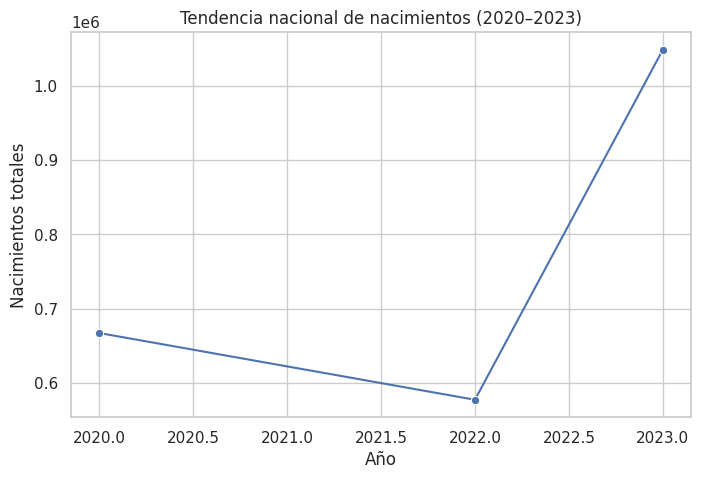

/tmp/ipython-input-4248617503.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top, x='nacimientos', y='departamento', palette='Blues_r')


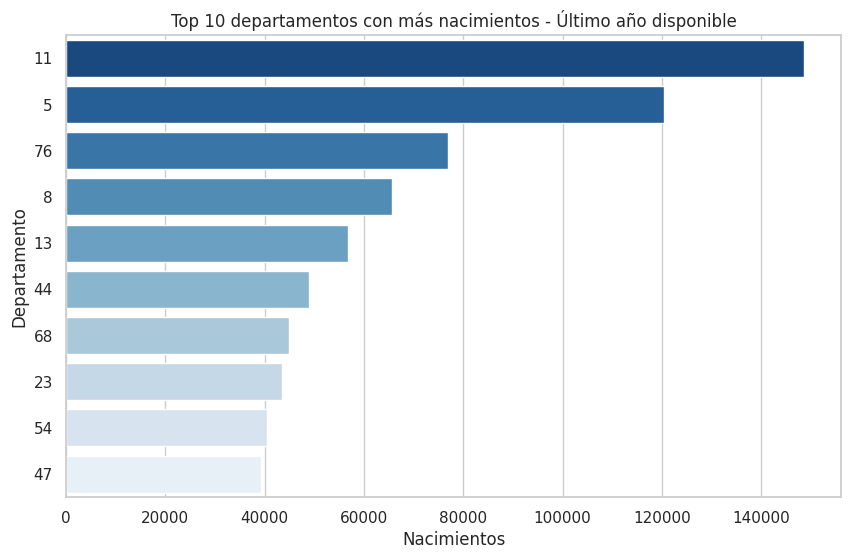

In [ ]:
# ======================================
# 5. COMPARACIÓN DE MODELOS
# ======================================
##Definición de los modelos#########
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
}
#Entrenamiento y evaluación####
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
#Cálculo de métricas de desempeño######
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)        # MSE estándar
    rmse = np.sqrt(mse)                            # RMSE calculado explícitamente
    r2 = r2_score(y_test, preds)
#Guardar los resultados#######
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

results_df = pd.DataFrame(results).T
print("\n📊 Resultados comparativos:")
display(results_df)
#Visualización de tendencias########
plt.figure(figsize=(8,5))
sns.lineplot(data=combined_clean, x='anio', y='nacimientos', estimator='sum', ci=None, marker='o')
plt.title('Tendencia nacional de nacimientos (2020–2023)')
plt.xlabel('Año')
plt.ylabel('Nacimientos totales')
plt.show()
#Visualización del top 10 departamentos####
plt.figure(figsize=(10,6))
top = combined_clean[combined_clean['anio']==combined_clean['anio'].max()] \
        .sort_values('nacimientos', ascending=False).head(10)
sns.barplot(data=top, x='nacimientos', y='departamento', palette='Blues_r')
plt.title('Top 10 departamentos con más nacimientos - Último año disponible')
plt.xlabel('Nacimientos')
plt.ylabel('Departamento')
plt.show()



📈 Proyección nacional total 2024: 1,182,958 nacimientos


/tmp/ipython-input-3408768542.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=proj_results.head(10), x='nacimientos_2024_pred', y='departamento', palette='Greens_r')


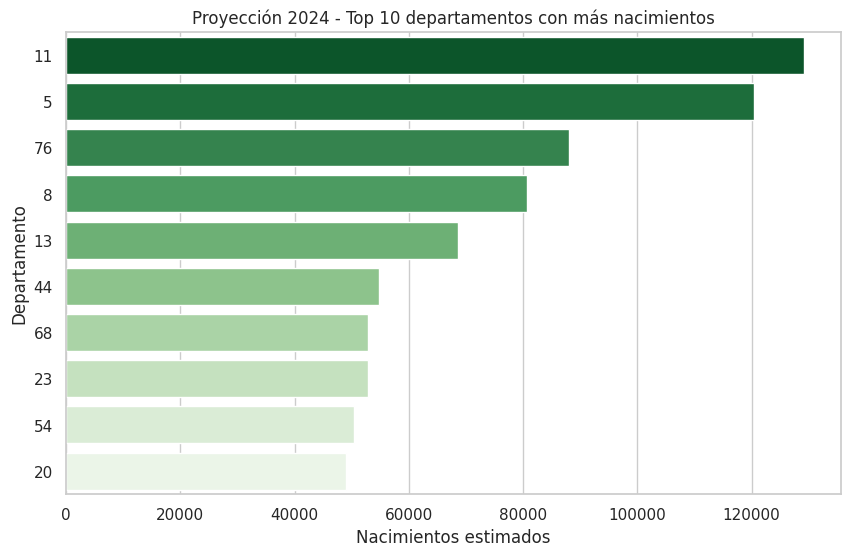

In [ ]:
# ======================================
# 6. ENTRENAMIENTO FINAL Y PROYECCIÓN 2024
# ======================================
#Entrena el modelo final con todos los datos históricos####
best_model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
best_model.fit(X, y)

# Crea la plantilla para predecir 2024
proj_rows = []
for dept, grp in combined_clean.groupby('departamento'):
    g = grp.sort_values('anio')
    val_2023 = g[g['anio']==2023]['nacimientos'].iloc[0] if 2023 in g['anio'].values else np.nan
    val_2022 = g[g['anio']==2022]['nacimientos'].iloc[0] if 2022 in g['anio'].values else np.nan
    if np.isnan(val_2023):
        val_2023 = g['nacimientos'].mean()
    nac_lag1 = val_2023
    nac_lag2 = val_2022 if not np.isnan(val_2022) else g['nacimientos'].mean()
    row = {'anio': 2024, 'nac_lag1': nac_lag1, 'nac_lag2': nac_lag2, 'dept_mean': g['nacimientos'].mean()}
  #Reconstruye variables dummy por departamento###
    for c in X.columns:
        if c.startswith('departamento_'):
            row[c] = 1 if c == f'departamento_{dept}' else 0
    proj_rows.append((dept, row))
#Convierte la lista en DataFrame y rellena columnas faltantes
proj_df = pd.DataFrame([r for _, r in proj_rows])
proj_df.index = [d for d, _ in proj_rows]
proj_df = proj_df.fillna(0)

# Asegurar mismas columnas que entrenamiento
missing_cols = set(X.columns) - set(proj_df.columns)
for c in missing_cols:
    proj_df[c] = 0
proj_df = proj_df[X.columns]
#Predice nacimientos para 2024
pred_2024 = best_model.predict(proj_df)
proj_results = pd.DataFrame({'departamento': proj_df.index, 'nacimientos_2024_pred': pred_2024})
proj_results = proj_results.sort_values('nacimientos_2024_pred', ascending=False)
#Calcula el total nacional
total_2024 = proj_results['nacimientos_2024_pred'].sum()
print(f"\n📈 Proyección nacional total 2024: {int(total_2024):,} nacimientos")
#Muestra gráfico del top 10
plt.figure(figsize=(10,6))
sns.barplot(data=proj_results.head(10), x='nacimientos_2024_pred', y='departamento', palette='Greens_r')
plt.title('Proyección 2024 - Top 10 departamentos con más nacimientos')
plt.xlabel('Nacimientos estimados')
plt.ylabel('Departamento')
plt.show()

In [ ]:
!jupyter nbconvert --to html /content/Copia_de_Untitled5.ipynb

[NbConvertApp] Converting notebook /content/Copia_de_Untitled5.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 562689 bytes to /content/Copia_de_Untitled5.html
